In [86]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

In [87]:
from keras import layers as L
from keras.models import Sequential

In [88]:
data = np.load('data/el_log.npy')

In [89]:
data.shape

(10000, 30, 30)

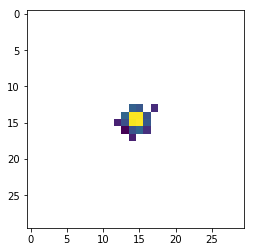

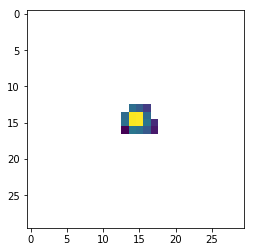

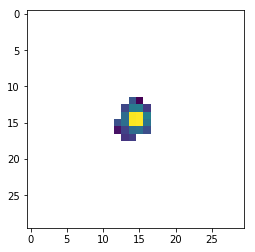

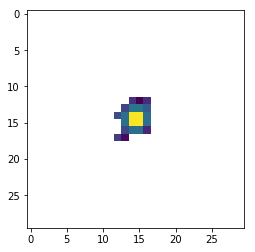

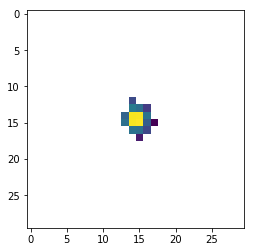

In [90]:
for im in data[:5]:
    plt.imshow(im)
    plt.show()

In [91]:
energy_data = np.log(1 + np.exp(data))

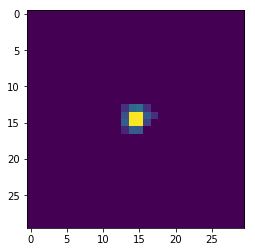

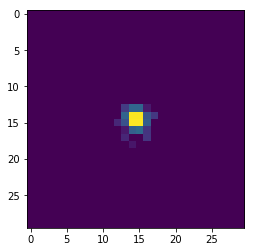

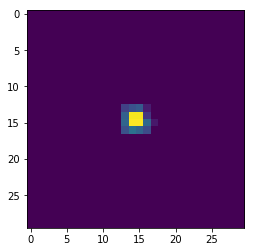

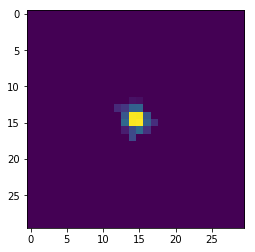

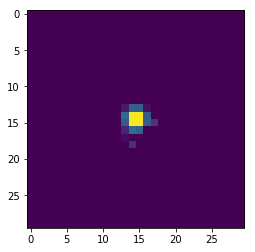

In [92]:
f = 10
for im in energy_data[f:f+5]:
    plt.imshow(im)
    plt.show()

In [93]:
energy_data[0].shape

(30, 30)

In [94]:
#L.Deconv2D?

In [96]:
L.Conv2D?

In [80]:
def build_generator(noise_shape):
    generator = Sequential()
    
    generator.add(L.InputLayer(input_shape=[noise_shape]))
    generator.add(L.Dense(7 * 7, activation='relu'))
    generator.add(L.Reshape((7, 7, 1)))
    generator.add(L.Deconv2D(128, kernel_size=5, activation='relu'))
    generator.add(L.Deconv2D(128, kernel_size=5, activation='relu'))
    generator.add(L.Deconv2D(64, kernel_size=5, activation='relu'))
    generator.add(L.Deconv2D(64, kernel_size=5, activation='relu'))
    generator.add(L.Deconv2D(32, kernel_size=4, activation='relu'))
    generator.add(L.Deconv2D(32, kernel_size=4, activation='relu'))
    generator.add(L.Deconv2D(16, kernel_size=4, activation='relu'))
    generator.add(L.Conv2D(1, kernel_size=3, activation='tanh'))
    
    return generator

def build_discriminator(img_shape):
    discriminator = Sequential()
    
    discriminator.add(L.InputLayer(img_shape))
    discriminator.add(L.Conv2D(32,kernel_size=3,activation='relu'))
    discriminator.add(L.MaxPool2D(pool_size=(2,2)))
    discriminator.add(L.Conv2D(32,kernel_size=3,activation='relu'))
    discriminator.add(L.Conv2D(64,kernel_size=3,activation='relu'))
    discriminator.add(L.Conv2D(64,kernel_size=3,activation='relu'))
    discriminator.add(L.MaxPool2D(pool_size=(2,2)))
    discriminator.add(L.Conv2D(128,kernel_size=3,activation='relu'))
    discriminator.add(L.Flatten())
    discriminator.add(L.Dense(256,activation='tanh'))
    discriminator.add(L.Dense(2,activation=tf.nn.log_softmax))
    
    return discriminator

In [81]:
def build_gan(disc_learn_rate = 1e-3, gen_learn_rate = 1e-2, noise_size = 100, image_size = (30, 30, 1)):
    gen = build_generator(noise_size)
    disc = build_discriminator(image_size)
    
    real_img = tf.placeholder(tf.float32,[None,]+ list(image_size))
    noise = tf.placeholder(tf.float32,[None, noise_size])
    
    gen_img = gen(noise)
    logits_on_real_data = disc(real_img)
    logits_on_gen_data = disc(gen_img)
    
    IS_REAL = 1
    IS_FAKE = 0
    
    disc_loss = -tf.reduce_mean(tf.nn.log_softmax(logits_on_real_data)[:, IS_REAL] + 
                                tf.nn.log_softmax(logits_on_gen_data)[:, IS_FAKE])
    disc_loss += tf.reduce_mean(disc.layers[-1].kernel ** 2)
    
    gen_loss = -tf.reduce_mean(tf.nn.log_softmax(logits_on_gen_data)[:, IS_REAL])
    
    train_gen = tf.train.GradientDescentOptimizer(learning_rate=gen_learn_rate).minimize(gen_loss, var_list = gen.trainable_weights)
    train_disc = tf.train.GradientDescentOptimizer(learning_rate=disc_learn_rate).minimize(disc_loss, var_list = disc.trainable_weights)
    return disc, gen, disc_loss, gen_loss, train_disc, train_gen, real_img, noise

In [82]:
def random_noise(a):
    noise = np.random.normal(size=(a, noise_size)).astype('float32')
    return noise

def random_data(bsize):
    ind = np.random.choice(np.arange(energy_data.shape[0]), size=bsize)
    data = energy_data[ind].reshape((-1, 30, 30, 1))
    return data

def sample_images(nrow, ncol):
    images = gen.predict(random_noise(nrow * ncol ))
    if np.var(images)!= 0:
        images = images.clip(np.min(energy_data), np.max(energy_data))
    for i in range(nrow * ncol):
        plt.subplot(nrow, ncol, i + 1)
        plt.imshow(images[i].reshape(30, 30))
    plt.show()

def sample_probas(bsize):
    plt.title('Generated vs real data')
    plt.hist(np.exp(disc.predict(random_data(bsize)))[:,1],
             label='D(x)', bins=100, alpha=0.5,range=[0,1])
    predict_on_generated = (np.exp(disc.predict(gen.predict(random_noise(1000))))[:,1])
    plt.hist(predict_on_generated, label='D(G(z))', bins=100, alpha=0.5,range=[0,1])
    plt.legend(loc='best')
    plt.show()
    return predict_on_generated.mean()

In [83]:
def play_the_game(k_disc, k_gen, disc, gen, disc_loss, gen_loss, train_disc, train_gen, real_img, noise, show_each = 100, check_each = 100, epochs = 100000):
    sess = tf.InteractiveSession(config = tf.ConfigProto(gpu_options = tf.GPUOptions(allow_growth = True)))
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(epochs):
        feed_dict = {
            real_img:random_data(100), 
            noise:random_noise(100)
        }
        
        for _ in range(k_disc):
            sess.run(train_disc, feed_dict)
        for _ in range(k_gen):
            sess.run(train_gen, feed_dict)
        
        if epoch % show_each==0:
            print("epoch", epoch)
            sample_images(1, 2)
            sample_images(1, 2)
        if epoch % check_each==0:
            if epoch % show_each != 0:
                print("epoch", epoch)
            discriminator_to_generator_trust = sample_probas(1000)
            if discriminator_to_generator_trust < 0.05:
                print("Generator lost the game around the epoch = ", epoch)
                return epoch
    return -1

epoch 0


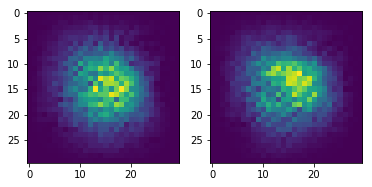

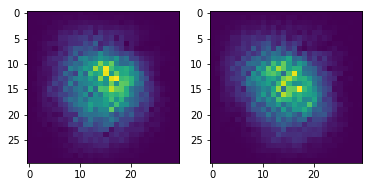

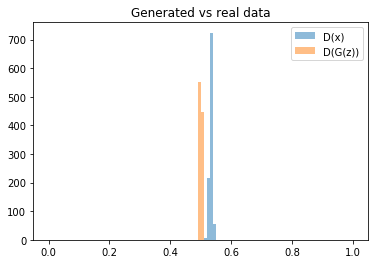

epoch 50


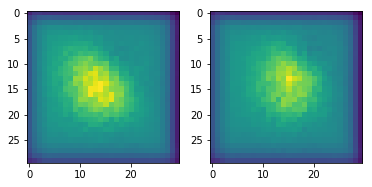

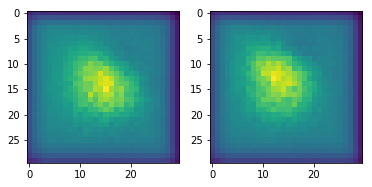

epoch 100


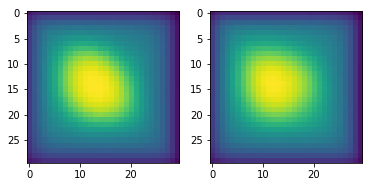

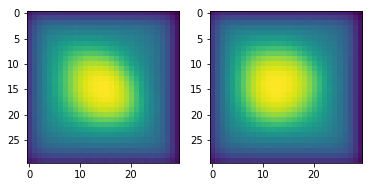

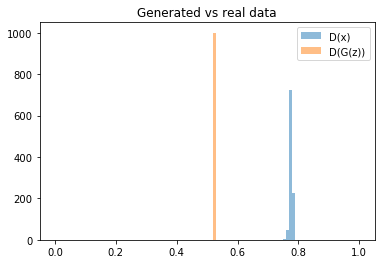

epoch 150


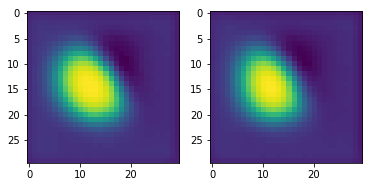

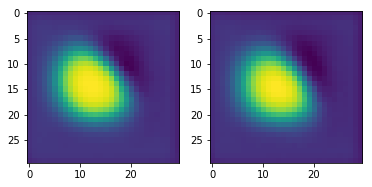

epoch 200


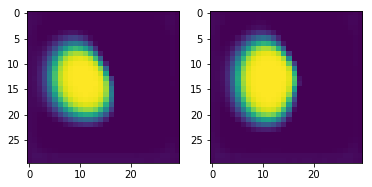

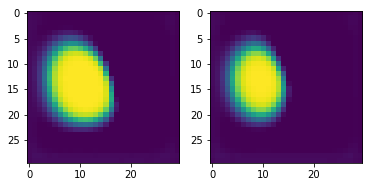

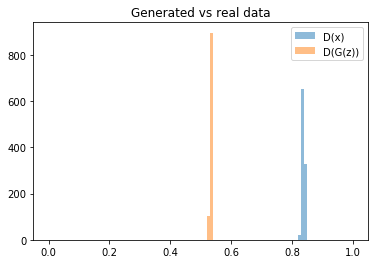

epoch 250


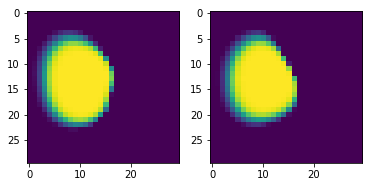

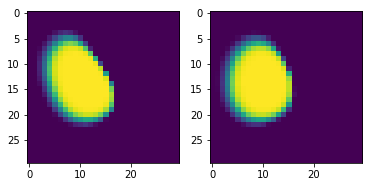

epoch 300


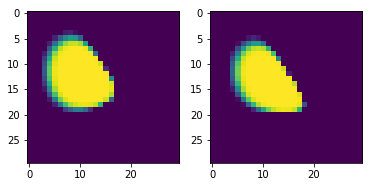

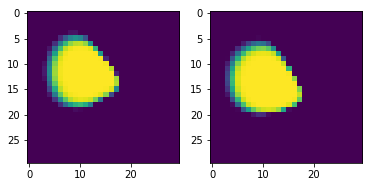

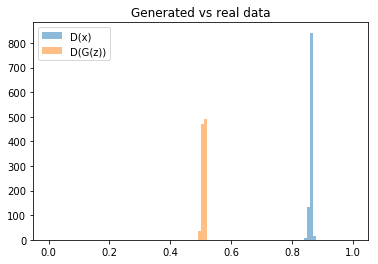

epoch 350


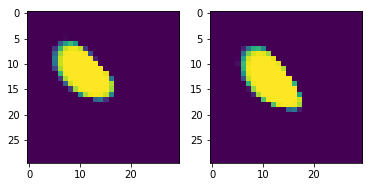

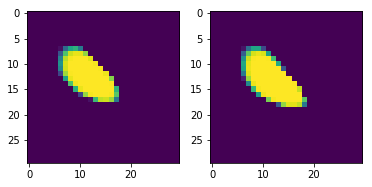

epoch 400


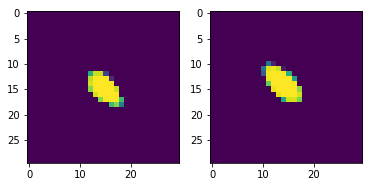

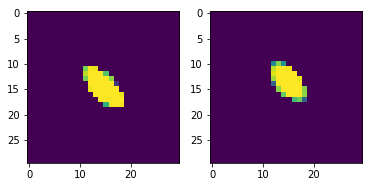

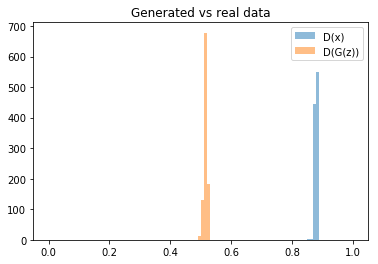

epoch 450


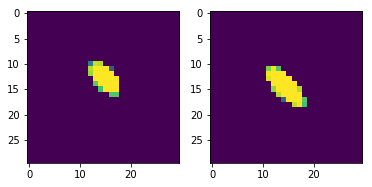

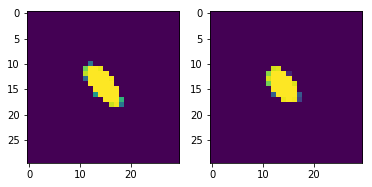

epoch 500


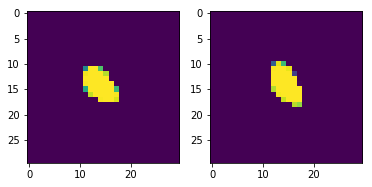

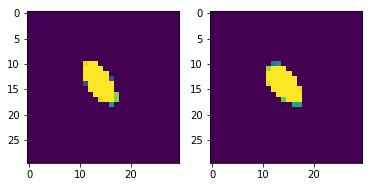

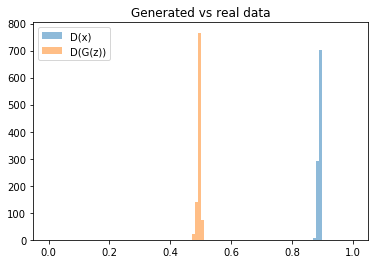

epoch 550


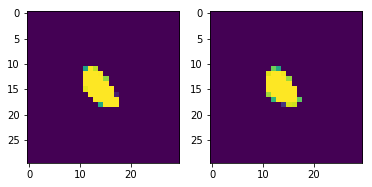

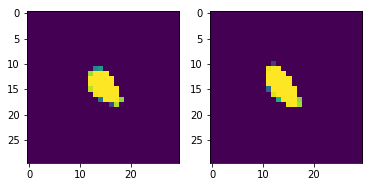

epoch 600


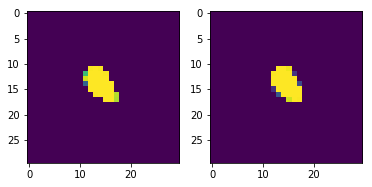

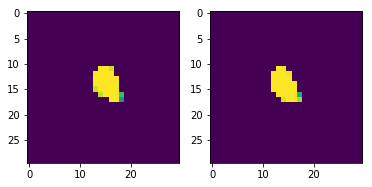

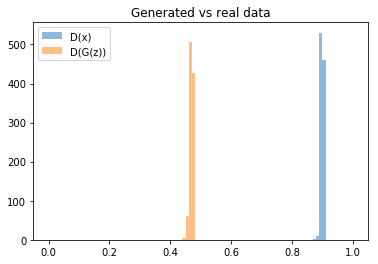

epoch 650


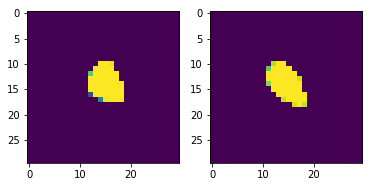

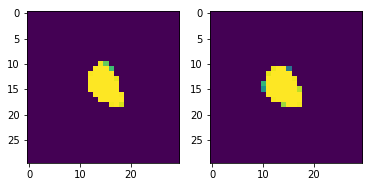

epoch 700


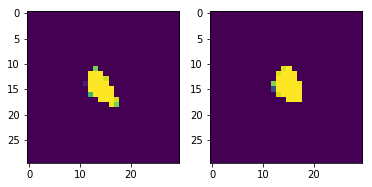

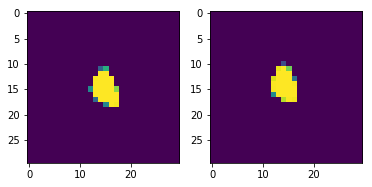

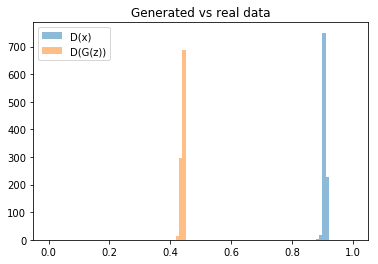

epoch 750


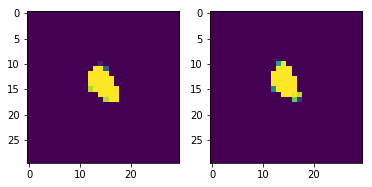

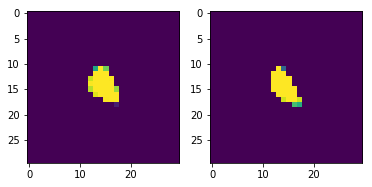

epoch 800


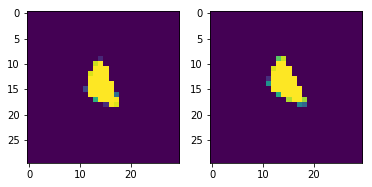

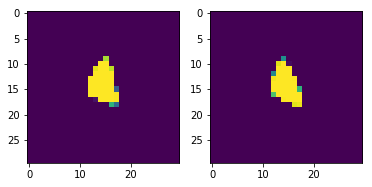

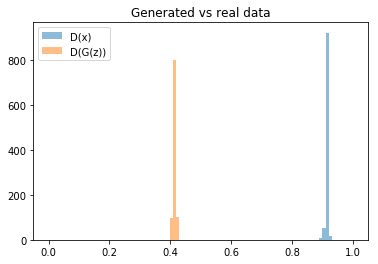

epoch 850


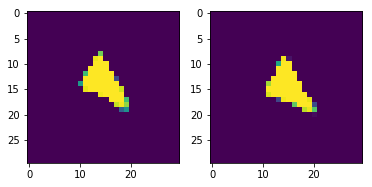

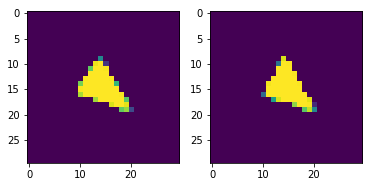

epoch 900


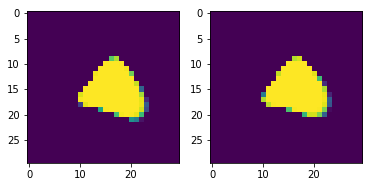

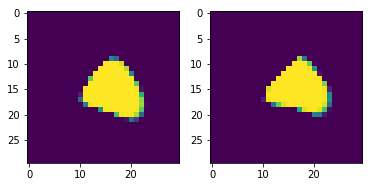

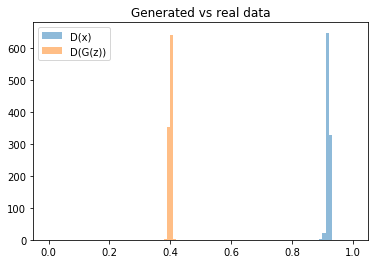

epoch 950


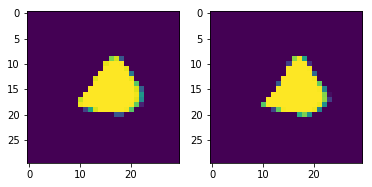

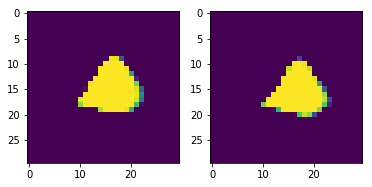

epoch 1000


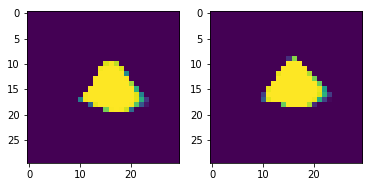

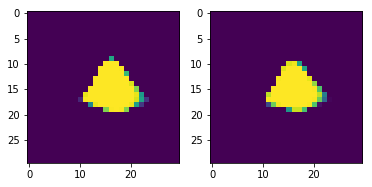

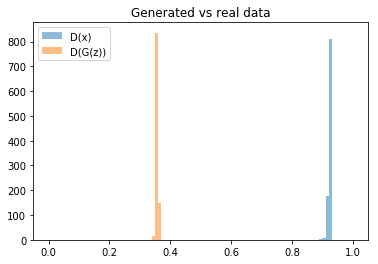

epoch 1050


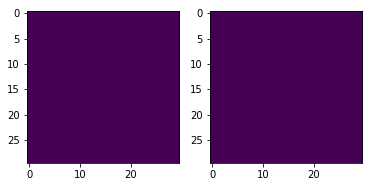

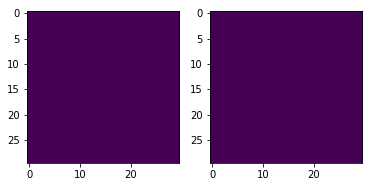

epoch 1100


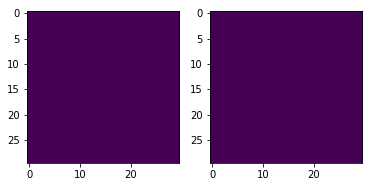

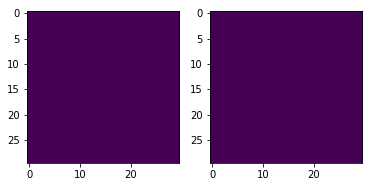

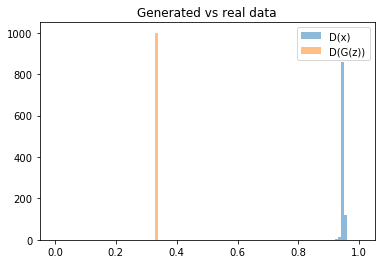

epoch 1150


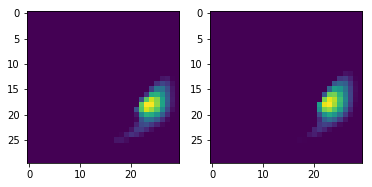

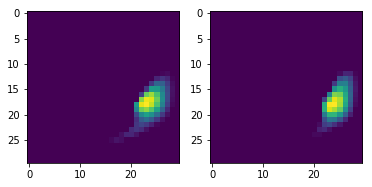

epoch 1200


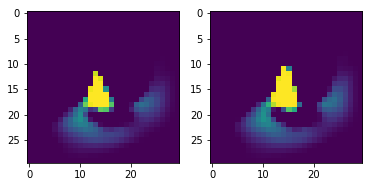

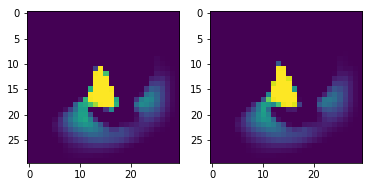

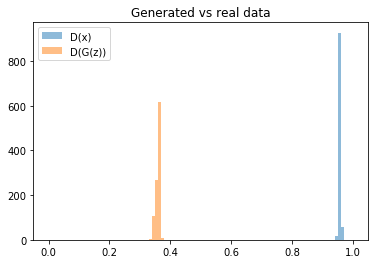

epoch 1250


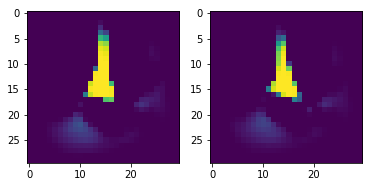

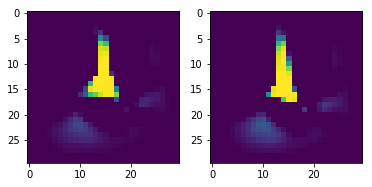

epoch 1300


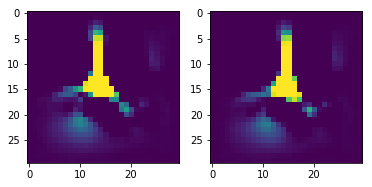

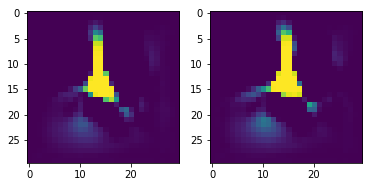

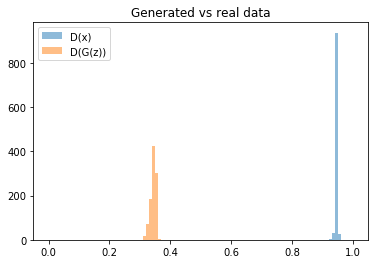

epoch 1350


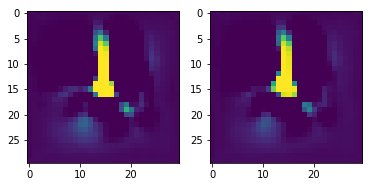

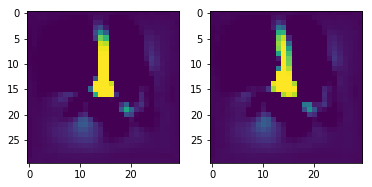

epoch 1400


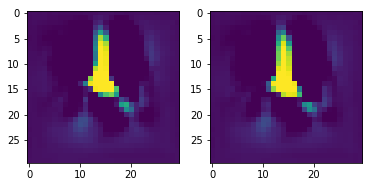

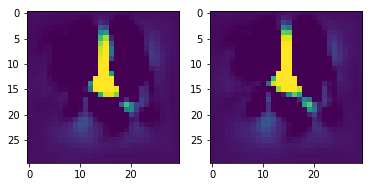

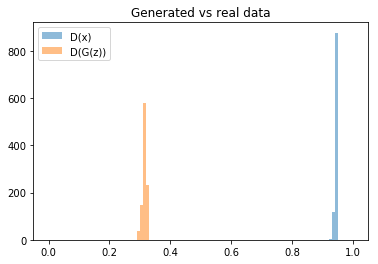

epoch 1450


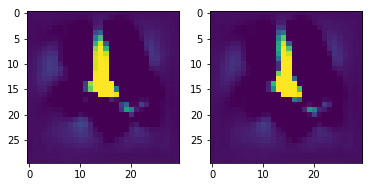

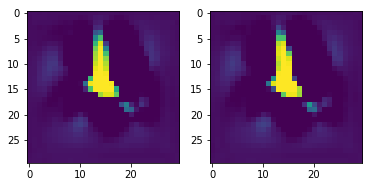

epoch 1500


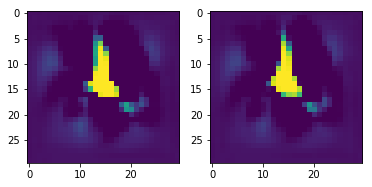

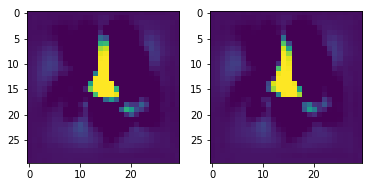

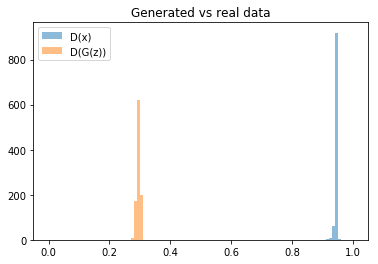

In [ ]:
k_disc = 2  # число обучений дискриминатора за эпоху
k_gen = 3  # число обучений генератора за эпоху
disc_learn_rate = 1e-4  # скорость обучения дискриминатора
gen_learn_rate = 1e-2  #скорость обучения генератора
epochs = 10000  # максимальное число эпох обучения
noise_size = 100
image_size = (30, 30, 1)
show_each = 50  # показывать каждую эпоху кратную ...
check_each = 100  # сравнивать работу дискриминатора на реальных и сгенерированных данных каждую эпоху кратную ...
disc, gen, disc_loss, gen_loss, train_disc, train_gen, real_img, noise = build_gan(disc_learn_rate, gen_learn_rate, noise_size, image_size)
%matplotlib inline
generator_lost_on_epoch = play_the_game(k_disc, k_gen, disc, gen, disc_loss, gen_loss, train_disc, train_gen, real_img, noise, show_each, check_each, epochs)

In [ ]:
E, E_first, E_second = np.zeros(10000), np.zeros(10000), np.zeros(10000)

for i in range(10000):
    E[i] = np.exp(data[i][14][14]) +  np.exp(data[i][15][14]) + np.exp(data[i][14][15]) + np.exp(data[i][15][15])
    for j in range(4):
        for k in range(4):
            if (j == 0 or j == 3 or k == 0 or k == 3):
                 E_first[i] += np.exp(data[i][13+j][13+k])
            if (j == 0 or j == 7 or k == 0 or k == 7):
                 E_second[i] += np.exp(data[i][11+j][11+k])
                    
plt.hist(E, 100, label='E0')
plt.legend(loc='best')
plt.show()
plt.hist(E_first, 100, label='E1')
plt.legend(loc='best')
plt.show()
plt.hist(E_second, 100, label='E2')
plt.legend(loc='best')
plt.show()

In [ ]:
def sample_x_images(size):
    images = gen.predict(random_noise(size)).reshape(-1,30,30)
    return images

In [ ]:
images = sample_x_images(1000)
exp_images = np.exp(images) - 1
exp_data = np.exp(data)
real_images = exp_images * exp_data.std(axis=0) + exp_data.mean(axis=0)

central_2 = np.sum(real_images[:, 14:16, 14:16], axis=(1, 2))

mask_4_2 = np.zeros((30, 30), dtype=bool)
mask_4_2[13:17, [13, 16]] = True
mask_4_2[[13, 16], 13:17] = True
    
central_4_2 = np.sum(real_images[:, mask_4_2], axis=1)
    
mask_6_4 = np.zeros((30, 30), dtype=bool)
mask_6_4[12:18, [12, 17]] = True
mask_6_4[[12, 17], 12:18] = True
    
central_6_4 = np.sum(real_images[:, mask_6_4], axis=1)

In [ ]:
plt.figure(figsize=(12,6))
plt.title('E1')
plt.hist([central_4_2, E_first], bins=100, label=['sample', 'real'], range=(0, 400))
plt.legend(loc='best')
plt.show()

In [ ]:
plt.figure(figsize=(8,4))
plt.title('E2')
plt.hist([central_6_4, E_second], bins=100, label=['sample', 'real'], range=(0, 30))
plt.legend(loc='best')
plt.show()

In [ ]:
plt.figure(figsize=(12,6))
plt.title('E')
plt.hist([central_2, E], bins=100, label=['sample', 'real'], range=(90000, 100000))
plt.legend(loc='best')
plt.show()